# **Capstone Project GRP4 NLP B**

In [61]:
from google.colab import drive

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, Flatten, GlobalMaxPool1D, SpatialDropout1D

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors # Gensim contains word2vec models and processing tools
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import binarize

from nltk import word_tokenize
from nltk.corpus import wordnet 

import os
import nltk
import string
import re

from collections import Counter
from nltk.corpus import stopwords
from translate import Translator
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
DetectorFactory.seed = 0

import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")

import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

from textblob import Word
from ftfy import fix_text
tf.__version__
#from googletrans import Translator
#translator = Translator(service_urls=['translate.googleapis.com'])
#!{sys.executable} -m pip install pypdf2
#!{sys.executable} -m pip install python-docx
#!{sys.executable} -m pip install python-docx2txt

'2.3.0'

In [68]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [34]:
!pip install -U textblob
!pip install translators
!pip install goslate
import goslate
!pip install translate
!pip install googletrans
import googletrans
from googletrans import Translator
!pip install langdetect
!pip install ftfy

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)


In [35]:
#### mounting google drive ####
drive.mount("/content/drive/")
folder_path = ("/content/drive/My Drive/") 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
ticket_data = pd.read_excel(folder_path+ "/input_data.xlsx")

In [37]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [38]:
ticket_data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [83]:
unique_callers = ticket_data['Caller'].unique()
unique_callers.shape

(2950,)

In [84]:
Func_group = ticket_data['Assignment group'].unique()
Func_group.shape

(74,)

In [85]:
TargetGroupCnt=ticket_data['Assignment group'].value_counts()
TargetGroupCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

In [86]:
ticket_data.Caller.value_counts()

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
epjwqaru mikoszpv      1
fduinmtw yofhirjs      1
kwyozxgd gasxctph      1
cieagtub vwyzjlqm      1
sgaczfvo wxmkrzfu      1
Name: Caller, Length: 2950, dtype: int64

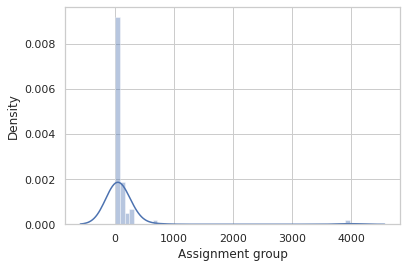

In [87]:
sns.distplot(ticket_data['Assignment group'].value_counts())

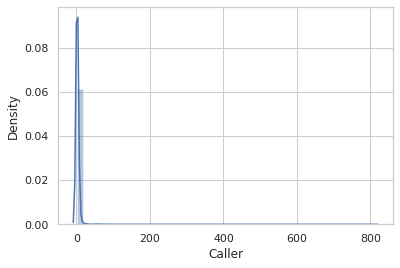

In [88]:
sns.distplot(ticket_data['Caller'].value_counts())

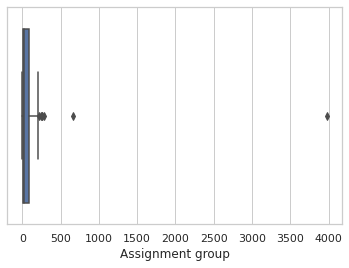

In [89]:
sns.boxplot(ticket_data['Assignment group'].value_counts())

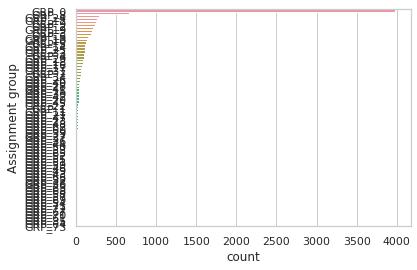

In [90]:
sns.countplot(y="Assignment group", data=ticket_data, order=ticket_data['Assignment group'].value_counts().index )

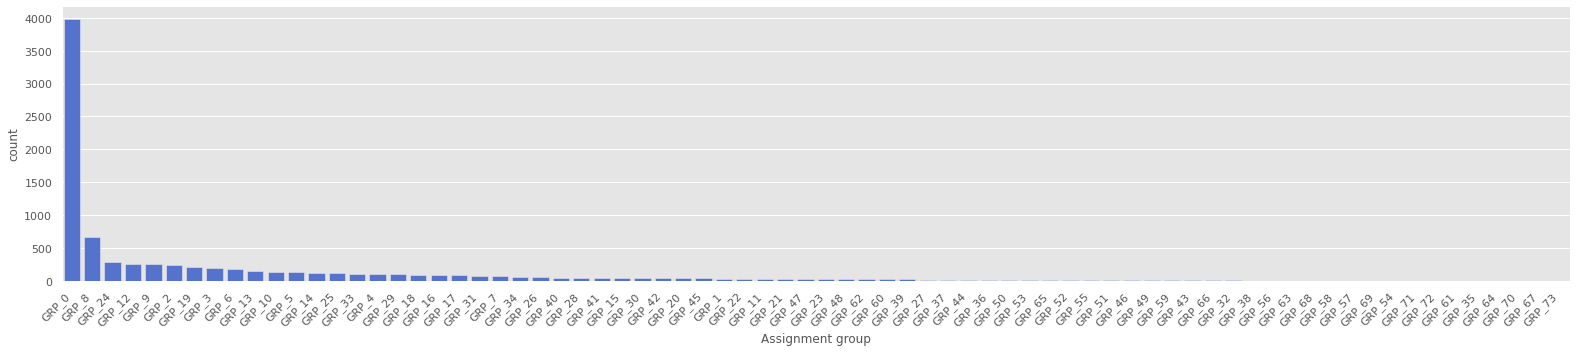

In [91]:
plt.style.use('ggplot')
%matplotlib inline

descending_order = ticket_data['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=ticket_data, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [93]:
ticket_data.isnull().values.any()

False

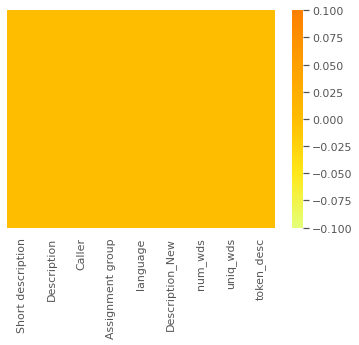

In [96]:
sns.heatmap(ticket_data.isnull(), yticklabels=False, cmap="Wistia")

In [95]:
ticket_data['Description'].fillna(value=' ', inplace=True)
ticket_data['Short description'].fillna(value=' ', inplace=True)
ticket_data.isnull().values.any()

False

In [39]:
summary_data=ticket_data.pivot_table(columns = "Assignment group",aggfunc='count')
summary_data

Assignment group,GRP_0,GRP_1,GRP_10,GRP_11,GRP_12,GRP_13,GRP_14,GRP_15,GRP_16,GRP_17,GRP_18,GRP_19,GRP_2,GRP_20,GRP_21,GRP_22,GRP_23,GRP_24,GRP_25,GRP_26,GRP_27,GRP_28,GRP_29,GRP_3,GRP_30,GRP_31,GRP_32,GRP_33,GRP_34,GRP_35,GRP_36,GRP_37,GRP_38,GRP_39,GRP_4,GRP_40,GRP_41,GRP_42,GRP_43,GRP_44,GRP_45,GRP_46,GRP_47,GRP_48,GRP_49,GRP_5,GRP_50,GRP_51,GRP_52,GRP_53,GRP_54,GRP_55,GRP_56,GRP_57,GRP_58,GRP_59,GRP_6,GRP_60,GRP_61,GRP_62,GRP_63,GRP_64,GRP_65,GRP_66,GRP_67,GRP_68,GRP_69,GRP_7,GRP_70,GRP_71,GRP_72,GRP_73,GRP_8,GRP_9
Caller,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252
Description,3975,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252
Short description,3969,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,61,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252


In [40]:
ticket_data['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [41]:
len(ticket_data['Assignment group'].unique())

74

In [42]:
df_assg = ticket_data['Assignment group'].value_counts().reset_index()
df_assg['percentage'] = (df_assg['Assignment group']/df_assg['Assignment group'].sum())*100
df_assg.head()

,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


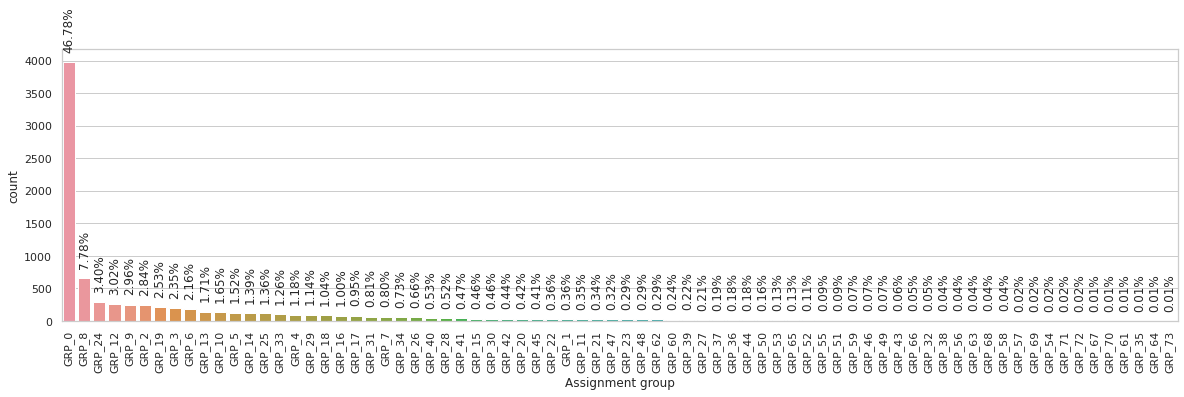

In [43]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=ticket_data, order=ticket_data["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(str(format(p.get_height()/len(ticket_data.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

#### Top 20 Assignment groups with highest number of tickets

In [44]:
df_top_assg = ticket_data['Assignment group'].value_counts().nlargest(20).reset_index()
df_top_assg

,index,Assignment group
0,GRP_0,3976
1,GRP_8,661
2,GRP_24,289
3,GRP_12,257
4,GRP_9,252
5,GRP_2,241
6,GRP_19,215
7,GRP_3,200
8,GRP_6,184
9,GRP_13,145


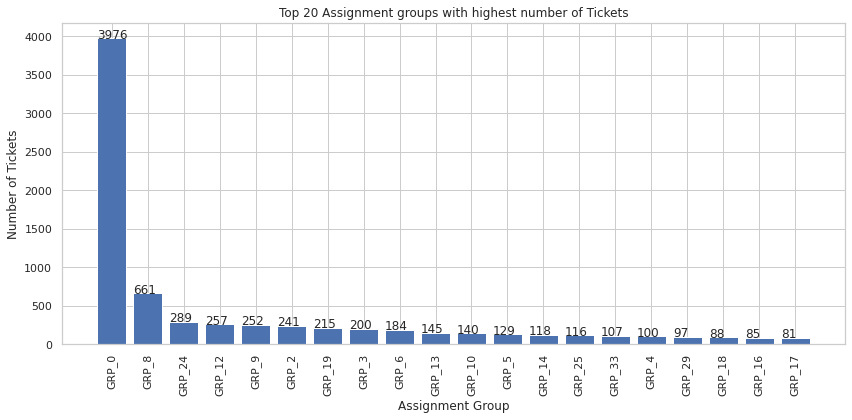

In [45]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_top_assg['index'],df_top_assg['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

#### Visualize the percentage of incidents per assignment group

In [46]:
df_bottom_assg = ticket_data['Assignment group'].value_counts().nsmallest(20).reset_index()
df_bottom_assg

,index,Assignment group
0,GRP_67,1
1,GRP_70,1
2,GRP_61,1
3,GRP_35,1
4,GRP_64,1
5,GRP_73,1
6,GRP_57,2
7,GRP_69,2
8,GRP_54,2
9,GRP_71,2


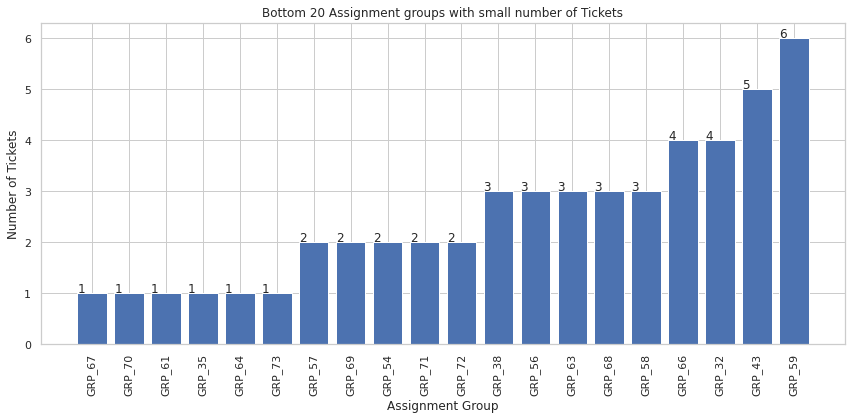

In [47]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_bottom_assg['index'],df_bottom_assg['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [48]:
df_tickets = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1','Ticket Count':len(df_assg[df_assg['Assignment group'] < 2])}
_2_5_ticket = {'Description':'2-5',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 1)& (df_assg['Assignment group'] < 6) ])}
_10_ticket = {'Description':' 6-10',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 5)& (df_assg['Assignment group'] < 11)])}
_10_20_ticket = {'Description':' 11-20',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 10)& (df_assg['Assignment group'] < 21)])}
_20_50_ticket = {'Description':' 21-50',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 20)& (df_assg['Assignment group'] < 51)])}
_51_100_ticket = {'Description':' 51-100',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 50)& (df_assg['Assignment group'] < 101)])}
_100_ticket = {'Description':' >100',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 100)])}
#append row to the dataframe
df_tickets = df_tickets.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

df_tickets

,Description,Ticket Count
0,1,6
1,2-5,13
2,6-10,6
3,11-20,9
4,21-50,16
5,51-100,9
6,>100,15


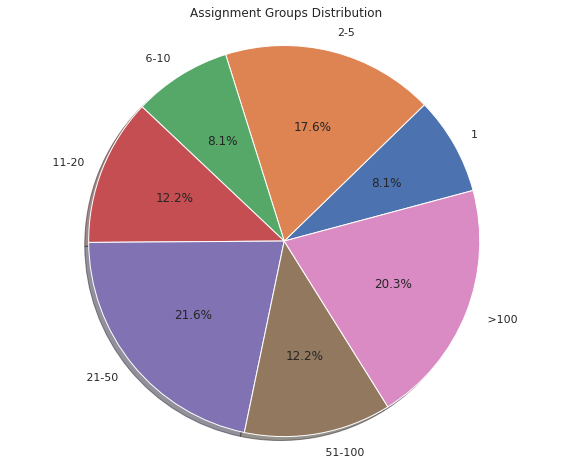

In [49]:
plt.figure(figsize=(10, 8))
plt.pie(df_tickets['Ticket Count'],labels=df_tickets['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution')
plt.axis('equal');

In [50]:
ticket_data[ticket_data['Short description'].isnull()]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0


In [51]:
ticket_data[ticket_data['Description'].isnull()]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [52]:
#Replace NaN values in Short Description and Description columns
ticket_data['Short description'] = ticket_data['Short description'].replace(np.nan, '', regex=True)
ticket_data['Description'] = ticket_data['Description'].replace(np.nan, '', regex=True)

In [53]:
#Lets encode the string, to make it easier to be passed to language detection api.
def fn_decode_to_ascii(df):
  text = df.encode().decode('utf-8').encode('ascii', 'ignore')
  return text.decode("utf-8") 

ticket_data['Description'] = ticket_data['Description'].apply(fn_decode_to_ascii)
ticket_data['Short description'] = ticket_data['Short description'].apply(fn_decode_to_ascii)

ftfy_ShortDescription = []
for Short_Description in Ticket_df['Short description']:
  ftfy_ShortDescription.append(fix_text(Short_Description))
Ticket_df['Short description']= ftfy_ShortDescription
ftfy_Description = []
for Description in Ticket_df['Description']:
  ftfy_Description.append(fix_text(Description))
Ticket_df['Description']= ftfy_Description

In [ ]:
#As different lines are of different length. We need to pad the our sequences using the max length
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [54]:
def get_text_from_translation(translation):
  print (translation.text)
  translated_text = translation.text.split("text")[1]
  translated_text = translated_text.split("Pronunciation")[0]
  translated_text = translated_text.split("=")[1]
  translated_text = translated_text.strip()
  translated_text = translated_text.replace(translated_text[len(translated_text)-1],"")
  return translated_text
def translate_word_by_word(sentence):
  words = sentence.split(" ")
  new_words = []
  for word in words:
    lang = detect(word)
    translator = Translator(provider='mymemory', to_lang="en", from_lang = lang, secret_access_key=None)
    new_word = translator.translate(word)
    new_words.append(new_word)
  return " ".join(new_words)
def translate_sentence(sentence):
  lang = detect(sentence)
  translator = Translator(provider='mymemory', to_lang="en", from_lang = lang, secret_access_key=None)
  return translator.translate(sentence)

In [55]:
def translate_column(columnvalue):  
  try:                                                          
    sentence_translated = translate_sentence(columnvalue)
    return sentence_translated
  except:                                                       
    return columnvalue                                                  

ticket_data['Description'] = ticket_data['Description'].apply(translate_column)

In [56]:
def detect_lang(desc):
  try:
    if desc != "":
      return detect(desc)
    else:
      return "en"
  except:
    return "en"
ticket_data['language'] = ticket_data['Description'].apply(detect_lang)

In [57]:
ticket_data["language"].value_counts()

en    7079
de     397
af     265
it     142
fr     111
no      74
ca      64
sv      58
es      58
nl      55
da      33
pl      31
pt      20
sl      19
tl      14
cy      14
ro      13
sq       9
et       9
hr       7
fi       5
id       5
so       5
lt       3
lv       3
sk       2
cs       2
sw       2
vi       1
Name: language, dtype: int64

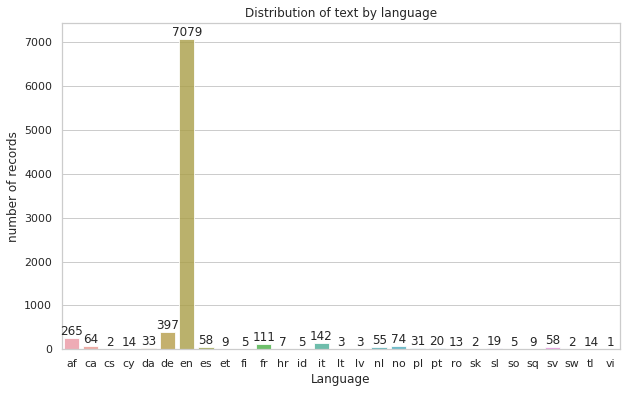

In [58]:
x = ticket_data["language"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

In [59]:
max_features = 10000
MAX_LENGTH = 300
embedding_size = 200

def clean_text(text):
    if text != "":          
      '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
      and remove words containing numbers.'''
      text=text.replace(('first name: ').lower(),'firstname')
      text=text.replace(('last name: ').lower(),'lastname')
      text=text.replace(('received from:').lower(),'')
      text=text.replace('email:','')
      text=text.replace('email address:','') 
      index1=text.find('from:')
      index2=text.find('\nsddubject:')
      text=text.replace(text[index1:index2],'')
      index3=text.find('[cid:image')
      index4=text.find(']')
      text=text.replace(text[index3:index4],'')
      text=text.replace('subject:','')
      text=text.replace('received from:','')
      text=text.replace('this message was sent from an unmonitored email address', '')
      text=text.replace('please do not reply to this message', '')
      text=text.replace('monitoring_tool@company.com','MonitoringTool')
      text=text.replace('select the following link to view the disclaimer in an alternate language','')
      text=text.replace('description problem', '') 
      text=text.replace('steps taken far', '')
      text=text.replace('customer job title', '')
      text=text.replace('sales engineer contact', '')
      text=text.replace('description of problem:', '')
      text=text.replace('steps taken so far', '')
      text=text.replace('please do the needful', '')
      text=text.replace('please note that ', '')
      text=text.replace('please find below', '')
      text=text.replace('date and time', '')
      text=text.replace('kindly refer mail', '')
      text=text.replace('name:', '')
      text=text.replace('language:', '')
      text=text.replace('customer number:', '')
      text=text.replace('telephone:', '')
      text=text.replace('summary:', '')
      text=text.replace('sincerely', '')
      text=text.replace('company inc', '')
      text=text.replace('importance:', '')
      text=text.replace('gmail.com', '')
      text=text.replace('company.com', '')
      text=text.replace('microsoftonline.com', '')
      text=text.replace('company.onmicrosoft.com', '')
      text=text.replace('hello', '')
      text=text.replace('hallo', '')
      text=text.replace('hi it team', '')
      text=text.replace('hi team', '')
      text=text.replace('hi', '')
      text=text.replace('best', '')
      text=text.replace('kind', '')
      text=text.replace('regards', '')
      text=text.replace('good morning', '')
      text=text.replace('please', '')
      text=text.replace('regards', '')
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'<br />', ' ', text)    
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
      text = re.sub(r'\S+@\S+', '', text)
      text = re.sub(r'\d+','' ,text)
      text = re.sub(r'#','', text)
      text = re.sub(r'&;?', 'and',text)
      text = re.sub(r'\&\w*;', '', text)
      text = re.sub(r'https?:\/\/.*\/\w*', '', text)
      custom_punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'
      text = re.sub(r'\w*\d\w*', '', text)
      text = re.sub(r'\[.*?\]', '', text)
      text = re.sub(r'https?://\S+|www\.\S+', '', text)
      text = re.sub(r'<.*?>+', '', text)
      text= ''.join(c for c in text if c <= '\uFFFF') 
      text = text.strip()      
      text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
      text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
      text = re.sub(r'\r\n', '', text)
      text = re.sub(r'\n', '', text)
      text = re.sub(r'\S+@\S+', '', text)

      text = text.lower()
    return text

ticket_data["Description"] = ticket_data["Description"].apply(clean_text)
ticket_data["Short description"] = ticket_data["Short description"].apply(clean_text)
ticket_data.head()

,Short description,Description,Caller,Assignment group,language
0,login issue,verified user detailsemployee manager nameche...,spxjnwir pjlcoqds,GRP_0,en
1,outlook,hmjdrvpbkomuaywn teammy meetingsskype meeting...,hmjdrvpb komuaywn,GRP_0,en
2,cant log in to vpn,eylqgodmybqkwiami cannot log on to vpn,eylqgodm ybqkwiam,GRP_0,en
3,unable to access hrtool page,unable to access hrtool page,xbkucsvz gcpydteq,GRP_0,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no


In [64]:
stop = stopwords.words('english')
ticket_data["Description"] = ticket_data["Description"].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
ticket_data["Short description"] = ticket_data["Short description"].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

add a filter for blank SD and D

In [65]:
# Function to translate the text to english.
def fn_translate(df,lang):
  try:
    if lang == 'en':
        return df
    else:
        return translator.translate(df).text
  except:
    return df

#ticket_data['Description'] = ticket_data.apply(lambda x: fn_translate(x['Description'], detect(x['language'])), axis=1)
#ticket_data['Short description'] = ticket_data.apply(lambda x: fn_translate(x['Short description'], detect(x['language'])), axis=1)

In [66]:
ticket_data.head()

,Short description,Description,Caller,Assignment group,language
0,login issue,verified user detailsemployee manager namechec...,spxjnwir pjlcoqds,GRP_0,en
1,outlook,hmjdrvpbkomuaywn teammy meetingsskype meetings...,hmjdrvpb komuaywn,GRP_0,en
2,cant log vpn,eylqgodmybqkwiami cannot log vpn,eylqgodm ybqkwiam,GRP_0,en
3,unable access hrtool page,unable access hrtool page,xbkucsvz gcpydteq,GRP_0,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no


In [69]:
ticket_data['Short description']= ticket_data['Short description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))
ticket_data['Description']= ticket_data['Description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

In [70]:
ticket_data['Description_New'] = ticket_data['Short description'] + ticket_data['Description']
ticket_data['num_wds'] = ticket_data['Description_New'].apply(lambda x: len(x.split()))
ticket_data['num_wds'].mean()

16.378470588235295

In [71]:
print(ticket_data['num_wds'].max())
print(ticket_data['num_wds'].min())

619
0


In [72]:
len(ticket_data[ticket_data['num_wds']==0])

46

In [73]:
ticket_data['uniq_wds'] = ticket_data['Description_New'].str.split().apply(lambda x: len(set(x)))
ticket_data['uniq_wds'].head()

0    15
1    12
2     5
3     5
4     3
Name: uniq_wds, dtype: int64

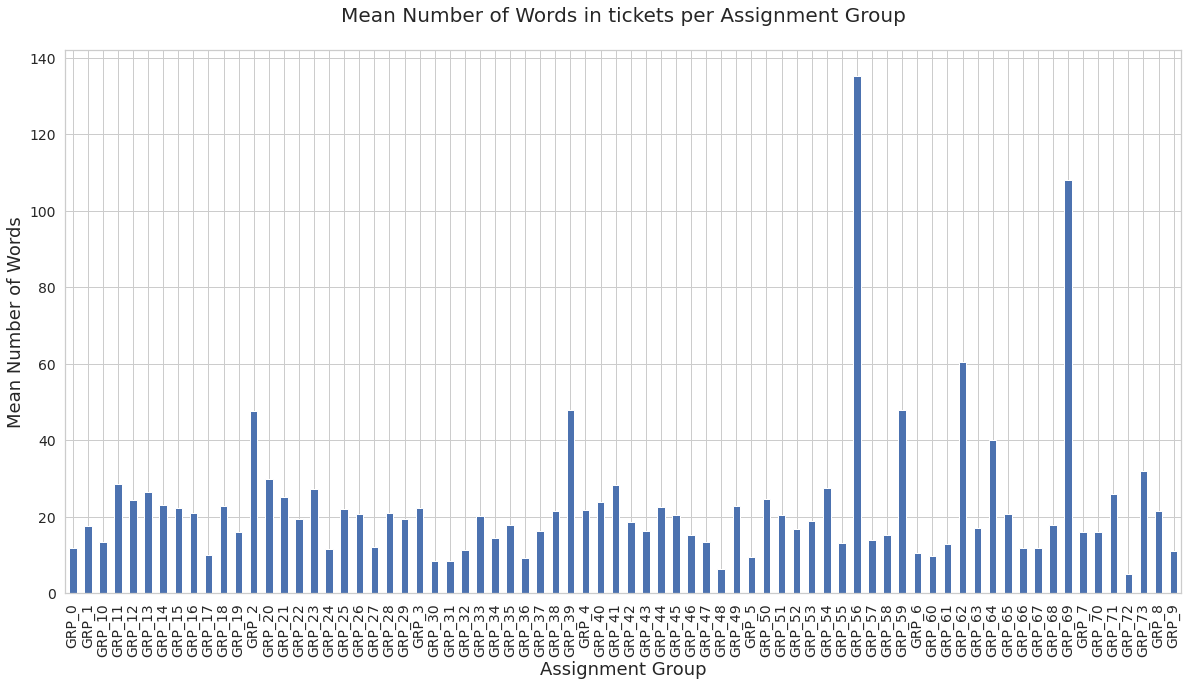

In [74]:
assign_grps = ticket_data.groupby('Assignment group')
ax=assign_grps['num_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(20,10))
ax.set_title('Mean Number of Words in tickets per Assignment Group\n', fontsize=20)
ax.set_ylabel('Mean Number of Words', fontsize=18)
ax.set_xlabel('Assignment Group', fontsize=18);

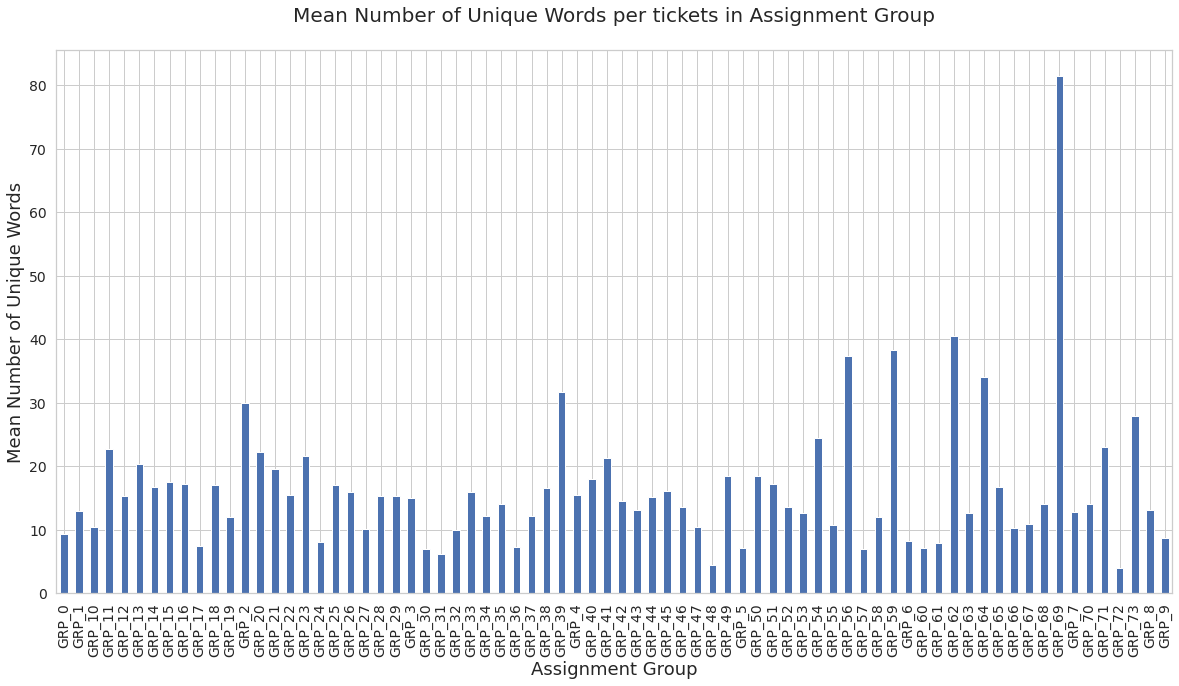

In [75]:
ax=assign_grps['uniq_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(20,10))
ax.set_title('Mean Number of Unique Words per tickets in Assignment Group\n', fontsize=20)
ax.set_ylabel('Mean Number of Unique Words', fontsize=18)
ax.set_xlabel('Assignment Group', fontsize=18);

In [78]:
word_counts = Counter()
for i, row in ticket_data.iterrows():
    word_counts.update(row['Description_New'].split())
    
word_counts.most_common(20)

[('password', 1800),
 ('failed', 1701),
 ('yesnona', 1568),
 ('erp', 1521),
 ('user', 1266),
 ('t', 1227),
 ('job', 1198),
 ('reset', 1121),
 ('access', 1001),
 ('account', 983),
 ('jobscheduler', 971),
 ('unable', 938),
 ('issue', 839),
 ('company', 813),
 ('error', 808),
 ('jobschedulermonitoringtooljob', 781),
 ('site', 774),
 ('need', 732),
 ('login', 731),
 ('ticket', 683)]

In [79]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
ticket_data['token_desc'] = ticket_data['Description_New'].apply(lambda x: tokenizer.tokenize(x))
ticket_data['token_desc'].head()

0    [login, issueverified, user, detailsemployee, ...
1    [outlookhmjdrvpbkomuaywn, teammy, meetingsskyp...
2    [cant, log, vpneylqgodmybqkwiami, cannot, log,...
3    [unable, access, hrtool, pageunable, access, h...
4                           [skype, errorskype, error]
Name: token_desc, dtype: object

In [81]:
def replace_with_synonym(sentence, perc_words):
    synonym = ""
    words = sentence.split(" ")
    repl_num = rnd.randint(0,100)
    repl_prob = False if repl_num > perc_words else True
    for word in words:
        if repl_prob:
            syns = wordnet.synsets(word)
            total = len(syns)
            if total>0:
                syn_idx = rnd.randint(0,total - 1)
                synonym = syns[syn_idx].lemmas()[0].name()
            if synonym != "":
                sentence = sentence.replace(word, synonym)
    return sentence
def scatter_sentences(para):
    sentences = para.split(".")
    i=0
    for sentence in sentences:
        sentences[i] = sentence.strip()
        i = i+1
    total = len(sentences)
    i = 0
    new_order = []
    while (len(new_order) < total):
        num = rnd.randint(0,total-1)
        if num not in new_order:
            new_order.append(num)
            i = i + 1
    new_sentences = [sentences[i] for i in new_order]
    return ". ".join(new_sentences)

In [82]:
print(scatter_sentences("Hi, I am abhijit. I work in Market Research. This is me trying to jumble sentences. A fourth sentence was added here for no reason."))
translation = translate_word_by_word("Hello, I am trying to translate this satz and generate data. drucker em93 (bei frau zeilmann) defekt: das papier wird wÃ¤hrend des druck- kopiervorganges geknittert.")
print(translation)
translation = translate_sentence("drucker em93 (bei frau zeilmann) defekt: das papier wird wÃ¤hrend des druck- kopiervorganges geknittert.")
print(translation)

A fourth sentence was added here for no reason. Hi, I am abhijit. This is me trying to jumble sentences. . I work in Market Research
Hello, I am trying to translate this Satz and GENERATE personal Printer in93 (for parenteral use) brittle zeilmann) Defect of paper sprint While of the Pressure copy processes crackled.
printer em93 (at Frau Zeilmann&#39;s) defective: the paper is creased during the print and copy process.


In [80]:
def vocabularize(text, max_features):
  x = text
  vocabSize = max_features
  tokenizer = Tokenizer(num_words=vocabSize, split=' ')
  tokenizer.fit_on_texts(x)
  x = tokenizer.texts_to_sequences(x)
  x = pad_sequences(x,MAX_LENGTH)
  return x
x = vocabularize(ticket_data["Description_New"], max_features)
x

array([[   0,    0,    0, ...,   34,  341,  186],
       [   0,    0,    0, ...,  291,  284,    6],
       [   0,    0,    0, ...,   55,   49,   50],
       ...,
       [   0,    0,    0, ...,    1,    8, 6967],
       [   0,    0,    0, ..., 1673, 5518,   29],
       [   0,    0,    0, ..., 1140, 2806, 2413]], dtype=int32)